In [7]:
import pandas as pd
import os.path
from core.util.math import compute_ft
import copy

from user_scripts.Timo.own.console_toolkit import Tk_file, Tk_string

Reload toolkit if changed

In [9]:
from importlib import reload  
reload(user_scripts.Timo.own.console_toolkit)
Tk_file

In [11]:
def load_pulsed_result(fname):
    return Tk_file.load_pulsed_result(fname)

def setup_clear_plots(n_plots):
    n_cur = qdplotlogic.number_of_plots
    for i in range(n_cur):
        n_cur_i = qdplotlogic.number_of_plots
        if n_cur_i >= 1:
            # removing without arguments seems buggy
            qdplotlogic.remove_plot(n_cur_i-1)
    
    for i in range(n_plots):
        qdplotlogic.add_plot()
        
def join_datapoints(mes, n=5):
    """
    calculates average over n datapoints.
    Eg. [0,1,2,3,4,5,6,7,8,9] -> [avg(0,1,2,3,4), avg(5,6,7,8,9)]
    """
    p_data = mes['data']
    mes_new = copy.deepcopy(mes)
    
    sub_arrays = []
    indices = np.arange(0, len(p_data), n)
    
    z = np.zeros((len(indices), 2))
    for i, idx in enumerate(indices):
        p_summed = p_data.iloc[idx:idx+n].sum()/n
        sub_arrays.append(p_summed)
        z[i,0] = p_summed.z1
        z[i,1] = p_summed.z2
    
    mes_new['data'] = pd.DataFrame(z, columns=['z1', 'z2'])
    
    # note: std is dropped here
    return mes_new
        
def plot_joined(idx_plot=0):
    plt.figure(figsize=(8,3))
    plt.subplot(121)
    plt.plot(z1_avg[idx_plot,:], label=f'z1, t= {t_s[idx_plot]/60:.1f} min')
    plt.plot(z2_avg[idx_plot,:], label='z2')
    plt.legend()
    plt.subplot(122)
    plt.plot(delta_avg[idx_plot,:], label='delta')

    plt.legend()
    plt.tight_layout()
    plt.show()

# Load qudi pulsed data

In [201]:
#path = r"E:\Data\2021\09\20210903\PulsedMeasurement\ise_rfdd_1"
#path = r"E:\Data\2021\09\20210910\PulsedMeasurement\ise_ramsey_rddd_iseOffRes_3"
path = r"E:\Data\2021\12\20211220\PulsedMeasurement\nv_20211215.6\lacpol_rf_1"
n_join_taus = 4
norm = True
reverse_phot_cumsum = False  # unravel photon summation done by fastcounter

In [203]:
mes_avg = []
mes = []
z1_avg, z1_avg = [], []

files = Tk_file.get_dir_items(path)
files_filter = Tk_string.filter_str(files, "pulsed_measurement.dat")

for f in files_filter:
    p = load_pulsed_result(f)
    mes.append(p)
    mes_avg.append(join_datapoints(p, n=n_join_taus))

n_taus  = len(mes_avg[0]['data'].z1)
z1_avg = np.asarray([p['data'].z1 for p in mes_avg])
z2_avg = np.asarray([p['data'].z2 for p in mes_avg])

if reverse_phot_cumsum:
    z1_avg = z1_avg - np.insert(z1_avg[:-1,:], [0], 0, axis=0)
    z2_avg=  z2_avg - np.insert(z2_avg[:-1,:], [0], 0, axis=0)
delta_avg = z2_avg-z1_avg 

if norm:
    #norm_ref = np.amax(z1_avg, axis=1)[:,None]
    norm_ref = np.average(z1_avg  + z2_avg, axis=1)[:,None]/2
    z1_avg = np.divide(z1_avg, norm_ref)
    z2_avg = np.divide(z2_avg, norm_ref)
    delta_avg = np.divide(delta_avg, norm_ref)

time = [p['date'] for p in mes_avg]
time = [t - time[0] for t in time]
t_s = np.asarray([t.total_seconds() for t in time])
n_ts = len(t_s)

z1_avg.shape

(17, 8)

In [1169]:
z1_avg.shape, files[0]

((7, 8), 'E:\\Data\\2021\\12\\20211216\\PulsedMeasurement\\laxpol_ramsey_rfdd_2/20211216-1105-10_ise+ramsey+rf_dd_i0000_laser_pulses.dat')

## debug loading

In [1100]:
files_filter[5]
[Tk_file.load_pulsed_result(files_filter[0])['date'], Tk_file.load_pulsed_result(files_filter[0])['file']]

[Timestamp('2021-12-16 11:05:10'), 'E:\\Data\\2021\\12\\20211216\\PulsedMeasurement\\laxpol_ramsey_rfdd_2/20211216-1105-10_ise+ramsey+rf_dd_i0000_pulsed_measurement.dat']

In [1103]:

p = load_pulsed_result(files_filter[0])
p['file']
p['data']
join_datapoints(p, n=8)

{'data':         z1       z2
0   96.934   96.356
1  104.465  103.093
2  106.727  104.877
3  106.751  105.395, 'file': 'E:\\Data\\2021\\12\\20211216\\PulsedMeasurement\\laxpol_ramsey_rfdd_2/20211216-1105-10_ise+ramsey+rf_dd_i0000_pulsed_measurement.dat', 'date': Timestamp('2021-12-16 11:05:10'), 'poi': 'nv_20211215_6'}

# Plotting

### Plot a few measurements

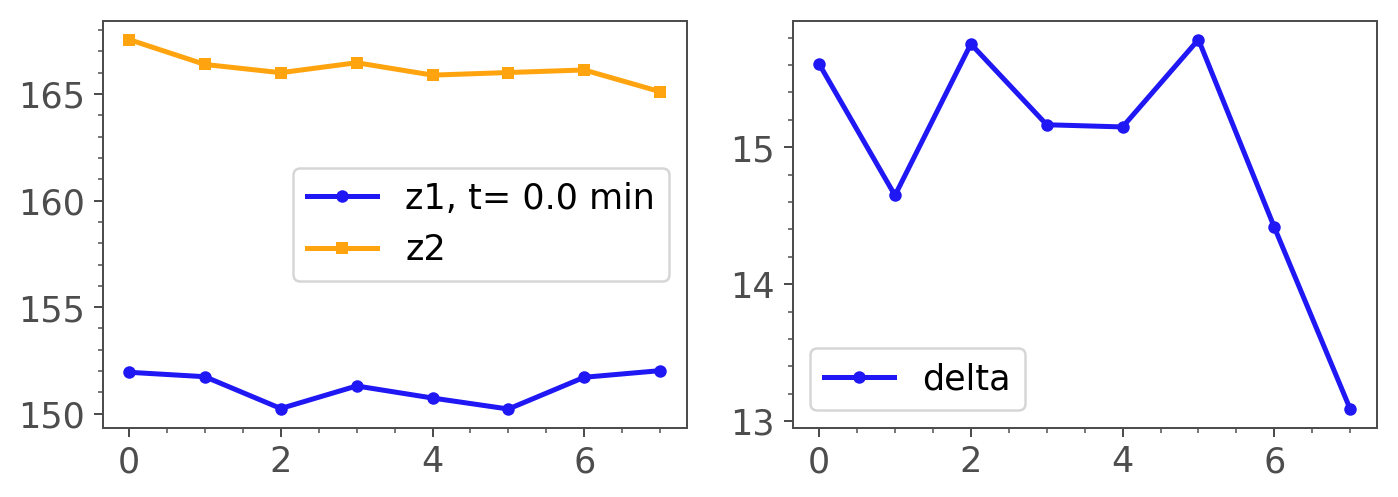

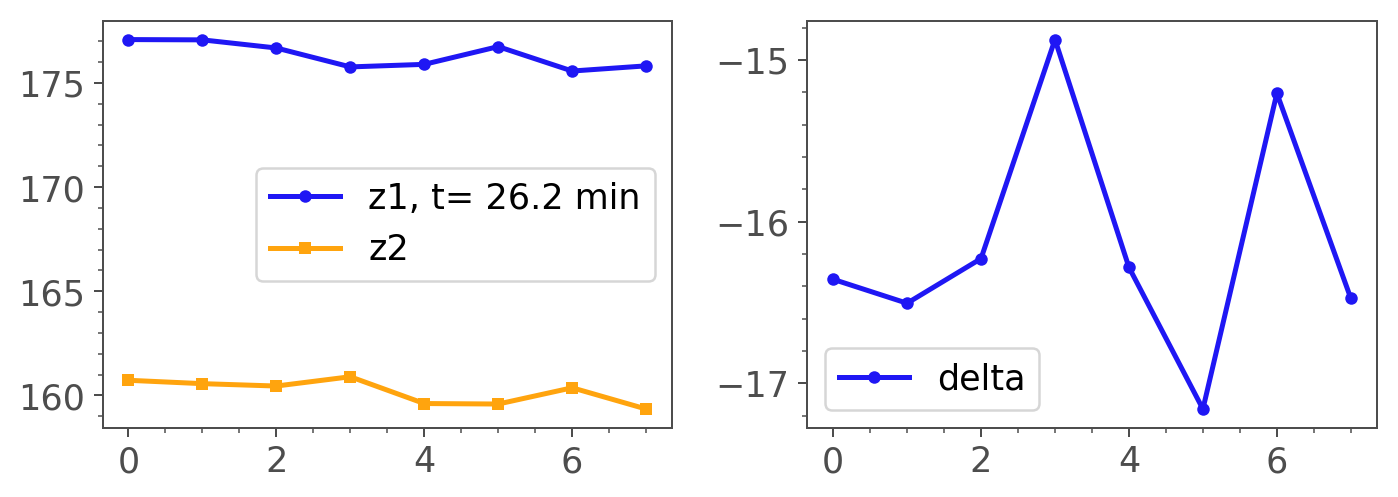

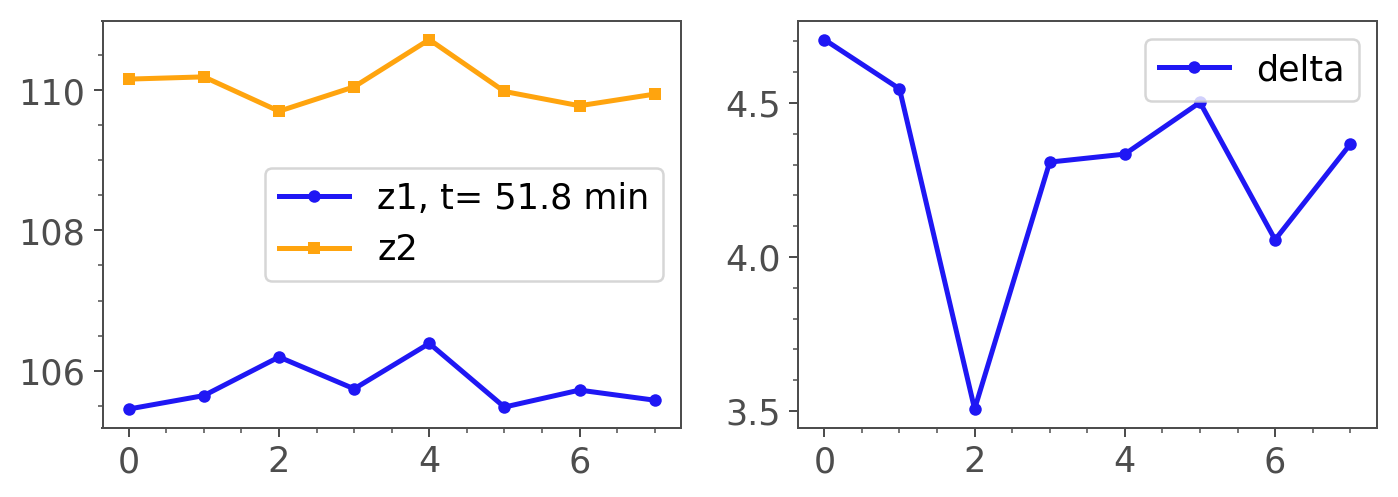

In [157]:
plot_joined(0)
#plot_joined(25)
#plot_joined(200)
plot_joined(int(n_ts/2))
plot_joined(-1)

### 2d plot

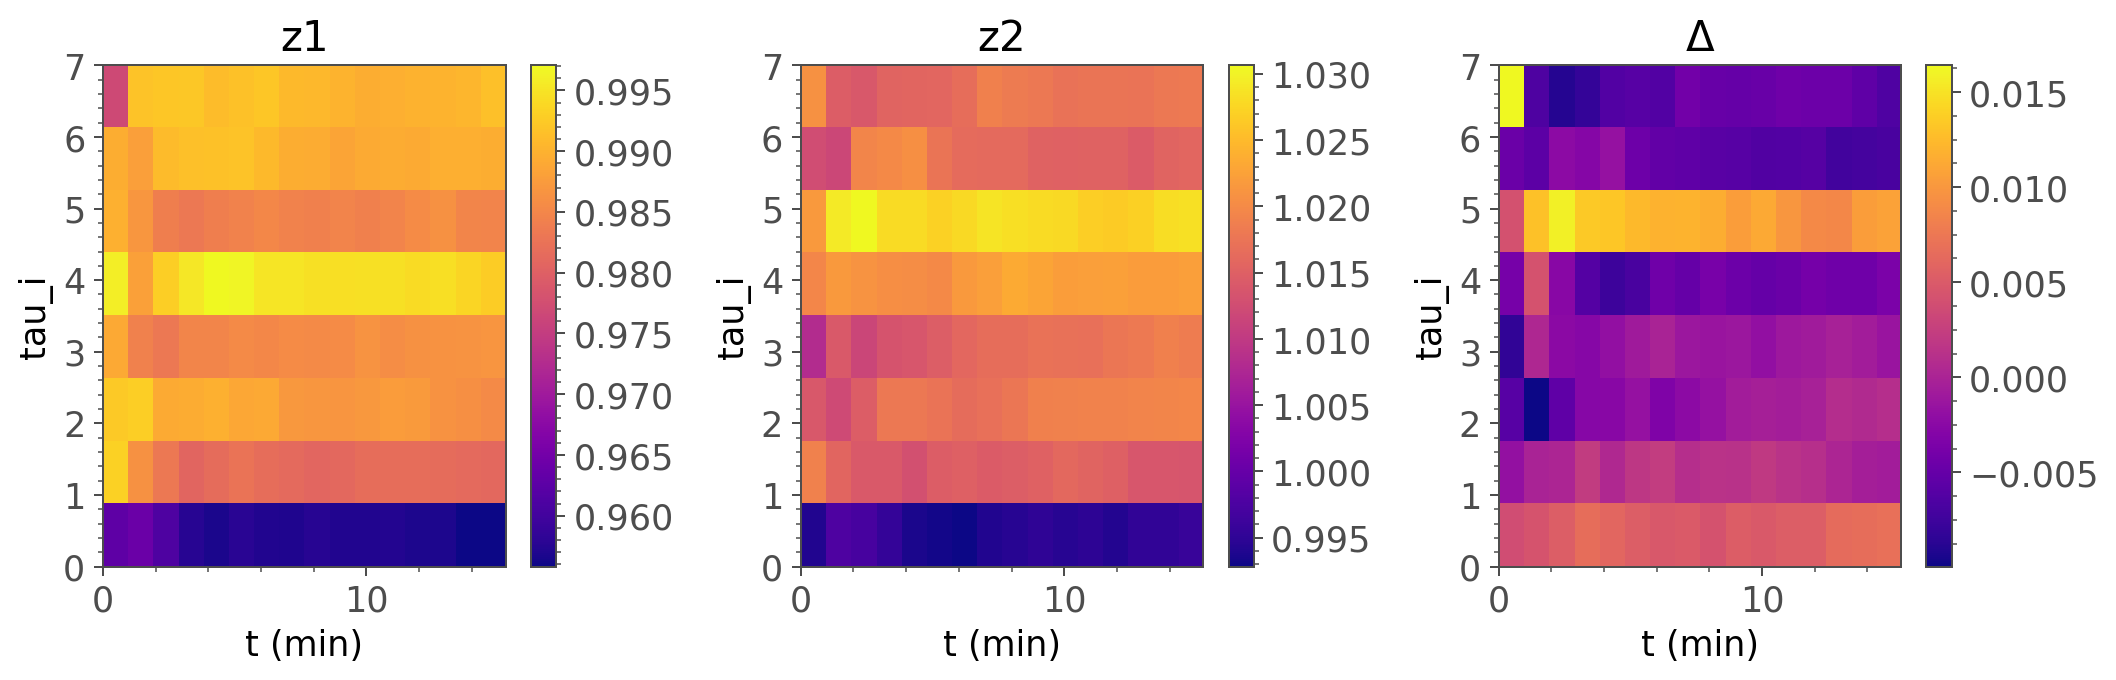

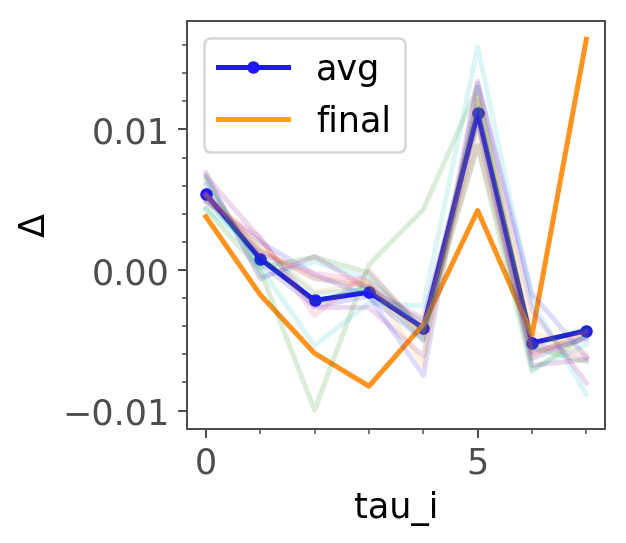

In [205]:
idx_zoom_end = -1

plt.figure(figsize=(12,4))

y_taus = np.arange(0, n_taus+1, 1)
ex = [t_s[0]/60, t_s[:idx_zoom_end][-1]/60, y_taus[0], y_taus[:idx_zoom_end][-1],]

plt.subplot(131)
plt.title("z1")
plt.imshow(np.transpose(z1_avg[:idx_zoom_end,:]),
           extent=ex,
           cmap='plasma', aspect='auto', origin='lower')
plt.xlabel("t (min)")
plt.ylabel("tau_i")
plt.colorbar()

plt.subplot(132)
plt.title("z2")
plt.imshow(np.transpose(z2_avg[:idx_zoom_end,:]),
           extent=ex,
           cmap='plasma', aspect='auto', origin='lower')
plt.xlabel("t (min)")
plt.ylabel("tau_i")
plt.colorbar()

plt.subplot(133)
plt.title(r"$\Delta$")
offset_ref_per_col = np.average(delta_avg[:idx_zoom_end,:], axis=1)[:,None]
plt.imshow(np.transpose(delta_avg[:idx_zoom_end,:]-offset_ref_per_col),
           extent=ex,
           cmap='plasma', aspect='auto', origin='lower')
plt.xlabel("t (min)")
plt.ylabel("tau_i")
plt.colorbar()

plt.tight_layout()
plt.show()



plt.figure(figsize=(3,3))
y_tau_avg = np.average(delta_avg[:idx_zoom_end,:], axis=0)
plt.plot(y_tau_avg-np.average(y_tau_avg), label='avg')
y_final = np.transpose(delta_avg[idx_zoom_end-idx_zoom_end,:])
plt.plot(y_final-np.average(y_final), label='final', marker='')
plt.plot(np.transpose(delta_avg[:idx_zoom_end]-offset_ref_per_col), alpha=0.15, marker='')

plt.legend()
plt.ylabel(r"$\Delta$")
plt.xlabel("tau_i")
plt.show()

In [1064]:
np.average(delta_avg[:idx_zoom_end,:], axis=1)[None,:]

array([[0.00818185, 0.01079954, 0.00886361, 0.01470405, 0.03199493,
        0.03908961, 0.04238863, 0.03978485]])

In [1049]:
norm_ref_per_col

array([[0.00818185],
       [0.01079954],
       [0.00886361],
       [0.01470405],
       [0.03199493],
       [0.03908961],
       [0.04238863],
       [0.03978485]])

In [941]:
delta_avg[idx_zoom_end,:]

In [932]:
idx_zoom_end

15

### Plot evolution of joined taus

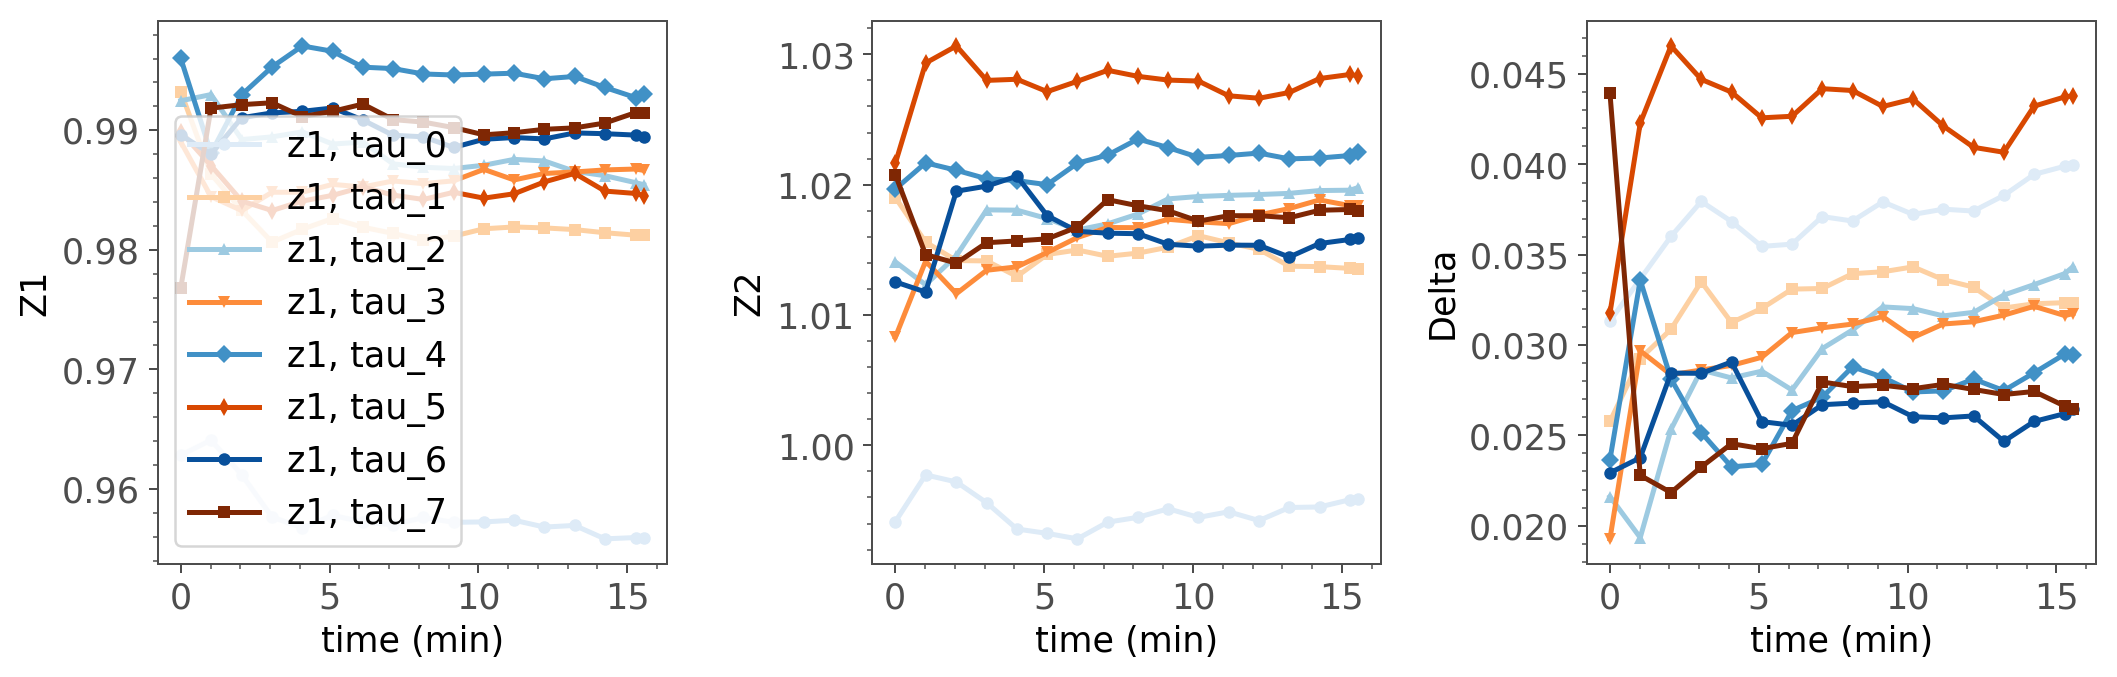

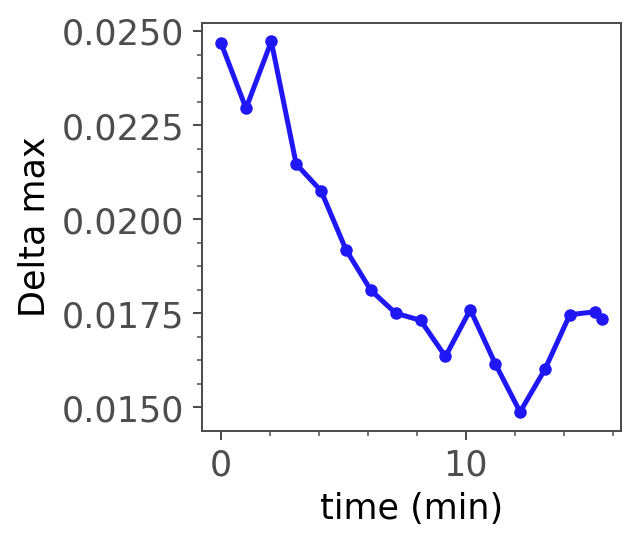

In [209]:
idx_zoom_end = 20


import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=n_taus)
cmap_blue = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap_yellow = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)

plt.figure(figsize=(12,4))
plt.subplot(131)

for tau_idx in range(0, n_taus):
    if tau_idx % 2 == 0:
        color = cmap_blue.to_rgba(tau_idx+1)
    else:
        color = cmap_yellow.to_rgba(tau_idx+1)
    plt.plot(t_s[:idx_zoom_end]/60, z1_avg[:idx_zoom_end,tau_idx], label=f'z1, tau_{tau_idx}',
            color=color)

plt.ylabel("Z1")
plt.xlabel("time (min)")
if n_taus < 10:
    plt.legend()


plt.subplot(132)

for tau_idx in range(0, n_taus):
    if tau_idx % 2 == 0:
        color = cmap_blue.to_rgba(tau_idx+1)
    else:
        color = cmap_yellow.to_rgba(tau_idx+1)
    plt.plot(t_s[:idx_zoom_end]/60, z2_avg[:idx_zoom_end,tau_idx], label=f'z2, tau_{tau_idx}',
            color=color)

plt.ylabel("Z2")
plt.xlabel("time (min)")
#plt.legend()


plt.subplot(133)


for tau_idx in range(0, n_taus):
    if tau_idx % 2 == 0:
        color = cmap_blue.to_rgba(tau_idx+1)
    else:
        color = cmap_yellow.to_rgba(tau_idx+1)
    plt.plot(t_s[:idx_zoom_end]/60, delta_avg[:idx_zoom_end,tau_idx], label=f'delta, tau_{tau_idx}',
            color=color)

plt.ylabel("Delta")
plt.xlabel("time (min)")
#plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(3,3))
delta_max = np.amax(delta_avg[:idx_zoom_end], axis=1) - np.amin(delta_avg[:idx_zoom_end], axis=1)
plt.plot(t_s[:idx_zoom_end]/60, delta_max, label=f'delta max')
plt.ylabel("Delta max")
plt.xlabel("time (min)")
plt.show()

In [335]:
np.amax(delta_avg[:idx_zoom_end], axis=1)

array([  8.126,  17.952,  23.356,  27.176,  32.84 ,  36.324,  39.46 ,
        42.522,  51.224,  60.79 ,  72.1  ,  83.3  ,  95.504, 105.22 ,
       113.392])

single data file

In [53]:
"""
fname = r"E:\Data\2021\06\20210622\PulsedMeasurement" + "\\" \
        + "20210622-1350-12_ramsey_deer_pi_df=3MHz_two_deer_pi_OffRes_pulsed_measurement.dat"
"""

fname = os.path.normpath(files_filter[0])
p_data = load_pulsed_result(fname)
0

0

array([ 0,  5, 10, 15, 20, 25, 30, 35])

# Plot in qudi plot

Need to activate qdplotgui first!

## Alternating: z1,z2; Delta (z1-z2); FFT(Delta) trace

In [147]:
x = np.asarray(t_s)
z1 =  np.asarray(z1_avg[:,0])
z2 = np.asarray(z2_avg[:,1])
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)

qdplotlogic.set_data(x, z1-z2, plot_index=1)

qdplotlogic.set_data(fft_x, fft_delta, plot_index=2)


0